<a href="https://colab.research.google.com/github/ThOpaque/Food_Recognition/blob/main/YOLO_MNIST_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, time,datetime
from timeit import default_timer as timer
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%pip install torchinfo;
%pip install torchmetrics;
from torchmetrics import MeanSquaredError;
from torchinfo import summary;

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_ONE_bounding_box_on_image(image, ymin:int, xmin:int, ymax:int, xmax:int, 
                               color:str='red', thickness:int=1, display_str:bool=None, 
                               use_normalized_coordinates:bool=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)



def draw_bounding_boxes_on_image(image, boxes:np.ndarray, color:list=[], 
                                 thickness:int=1, display_str_list:tuple=()):
  """Draws bounding boxes on image.

  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  
  for i in range(boxes_shape[0]):
    draw_ONE_bounding_box_on_image(image, 
                                   boxes[i, 1], boxes[i, 0], 
                                   boxes[i, 3], boxes[i, 2], 
                                   color[i], thickness, display_str_list[i])


def draw_bounding_boxes_on_image_array(image:np.ndarray, boxes:np.ndarray, color:list=[], 
                                       thickness:int=1, display_str_list:tuple=()):
  """Draws bounding boxes on image (numpy array).

  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
  return np.array(rgbimg)

In [3]:
############### Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
################################################################################

In [201]:
################################################################################
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
  """Utility to display a row of digits with their predictions.

  Args:
    digits : np.ndarray of shape (N,75,75,1)
        Raw image with normalized pixel values (from 0 to 1)
    predictions : np.ndarray of shape (N,)
        Predicted label with the same shape as labels
    labels : np.ndarray of shape (N,)
        Labels of the digits (from 0 to 9)
    pred_bboxes : np.ndarray of shape (n, N) ??
        Predicted bboxes locations
    bboxes : np.ndarray of shape (n, N)
        Ground true bboxe locations
    iou : list of shape (???)
        IoU of each bboxes
    title : str
        Figure's title
  """
  n = 10
  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    # If multiple bboxes
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    # If multiple bboxes predicted
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    # If multiple ground truth bboxes
    n_bboxes = bboxes[indexes,:]

  # Rescale pixel values to un-normed values (from 0 -black- to 255 -white-)
  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)

  # Set plot config
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])
    
    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])
    
    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)
################################################################################

################################################################################
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  """
  Pull a batch from the datasets. This code is not very nice.
  
  Args:
    training_dataset : torch.utils.data.Dataset
        Dataset from the torch.utils.data.Dataset Pytorch class, returning the 
        training digits, labels and bboxes coordinates as batches such as : 
            - training digits : torch.Tensor of shape (batch_size, 1, 75, 75)
            - labels : torch.Tensor of shape (batch_size, 10)
            - bboxes coordinates : torch.Tensor of shape (batch_size, 4)
    validation_dataset : torch.utils.data.Dataset 
        Dataset from the torch.utils.data.Dataset Pytorch class, returning the 
        whole validation digits, labels and bboxes coordinates.
    N : int
        Size of the training sample to extract from the training dataset

  Returns:
    N_train_ds_digits : np.ndarray of shape (N, 1, 75, 75)
    N_train_ds_labels : np.ndarray of shape (N, 10)
    N_train_ds_bboxes : np.ndarray of shape (N, 4)
    validation_digits : np.ndarray of shape (len(validation_dataset), 1, 75, 75)
    validation_labels : np.ndarray of shape (len(validation_dataset), 10)
    validation_bboxes : np.ndarray of shape (len(validation_dataset), 4)
  """
  ### get N training digits, labels and bboxes from one batch
  ### turning the bboxes coordinates into ndarrays
  one_batch_train_ds_digits, one_batch_train_ds_labels, one_batch_train_ds_bboxes, _ = next(iter(training_dataset))
  N_train_ds_digits = one_batch_train_ds_digits[:N].numpy()
  N_train_ds_labels = one_batch_train_ds_labels[:N].numpy()
  
  N_train_ds_bboxes = one_batch_train_ds_bboxes[:N].numpy()
  N_train_ds_bboxes_abs = N_train_ds_bboxes.copy()
  
  N_train_ds_bboxes_abs[:,0] = N_train_ds_bboxes[:,0] - (N_train_ds_bboxes[:,2]/2)
  N_train_ds_bboxes_abs[:,1] = N_train_ds_bboxes[:,1] - (N_train_ds_bboxes[:,3]/2)
  N_train_ds_bboxes_abs[:,2] = N_train_ds_bboxes[:,0] + (N_train_ds_bboxes[:,2]/2)
  N_train_ds_bboxes_abs[:,3] = N_train_ds_bboxes[:,1] + (N_train_ds_bboxes[:,3]/2)
  
  ### get the whole validation digits, labels and bboxes
  ### turning the bboxes coordinates into ndarrays
  for validation_digits, validation_labels, validation_bboxes, _ in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break

  # turning one hot encoding labels into the corresponding digit
  validation_labels = np.argmax(validation_labels, axis=1)
  N_train_ds_labels = np.argmax(N_train_ds_labels, axis=1)

  return (N_train_ds_digits, N_train_ds_labels, N_train_ds_bboxes_abs,
          validation_digits, validation_labels, validation_bboxes)

In [5]:
### Choosing device between CPU or GPU
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('mps') if torch.has_mps else torch.device('cpu')
print("\n------------------------------------")
print(f"Execute notebook on - {device} -")
print("------------------------------------\n")


------------------------------------
Execute notebook on - mps -
------------------------------------



In [6]:
def numpy_pad_to_bounding_box(image, offset_height=0, offset_width=0, target_height=0, target_width=0):
    assert image.shape[:-1][0] <= target_height-offset_height, "height must be <= target - offset"
    assert image.shape[:-1][1] <= target_width-offset_width, "width must be <= target - offset"
    
    target_array = np.zeros((target_height, target_width, image.shape[-1]))

    for k in range(image.shape[0]):
        target_array[offset_height+k][offset_width:image.shape[1]+offset_width] = image[k]
    
    return target_array

In [219]:
class my_mnist_dataset(torch.utils.data.Dataset):
    def __init__(self, root:str, split:str=None, download:bool=False):
        assert split, "You have to specify the split."
        
        if split == "train":
            train = True
        elif split == "test":
            train = False
        
        self.dataset = torchvision.datasets.MNIST(root=root, train=train, download=download)

    def __len__(self):
        return len(self.dataset)

    def transform_pasting75(self, image, label):
        ### xmin, ymin of digit
        xmin = torch.randint(0, 48, (1,))
        ymin = torch.randint(0, 48, (1,))
        
        image = torchvision.transforms.ToTensor()(image)
        image = torch.reshape(image, (28,28,1,))
        image = torch.from_numpy(numpy_pad_to_bounding_box(image, ymin, xmin, 75, 75))
        image = image.permute(2, 0, 1) #(C,H,W)
        image = image.to(torch.float)
        
        xmin, ymin = xmin.to(torch.float), ymin.to(torch.float)
        # xmin, ymin, xmax, ymax of bbox
        xmax_bbox = (xmin + 28)
        ymax_bbox = (ymin + 28)
        xmin_bbox = xmin
        ymin_bbox = ymin

        cx = (xmin+((xmax_bbox-xmin_bbox)/2)) / 75
        cy = (ymin+((ymax_bbox-ymin_bbox)/2)) / 75
        w = (xmax_bbox-xmin_bbox) / 75
        h = (ymax_bbox-ymin_bbox) / 75


        label_one_hot = F.one_hot(torch.as_tensor(label, dtype=torch.int64), 10)
        bbox_coord = torch.Tensor([cx, cy, w, h])

        return image, label_one_hot, bbox_coord

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image, one_hot_label, bbox_coord = self.transform_pasting75(self.dataset[idx][0], self.dataset[idx][1])
        
        return (image, one_hot_label.to(torch.float), bbox_coord, torch.tensor([1]))


In [220]:
def get_training_dataset(BATCH_SIZE=64):
    """
    Loads and maps the training split of the dataset using the custom dataset class. 
    """
    dataset = my_mnist_dataset(root="data", split="train", download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return dataloader, len(dataset)

def get_validation_dataset(BATCH_SIZE = None):
    """
    Loads and maps the validation split of the datasetusing the custom dataset class. 
    """
    dataset = my_mnist_dataset(root="data", split="test", download=True)
    if BATCH_SIZE is None:
        BATCH_SIZE = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    return dataloader, len(dataset)

# instantiate the datasets
training_dataset, len_training_ds = get_training_dataset()
validation_dataset, len_validation_ds = get_validation_dataset()

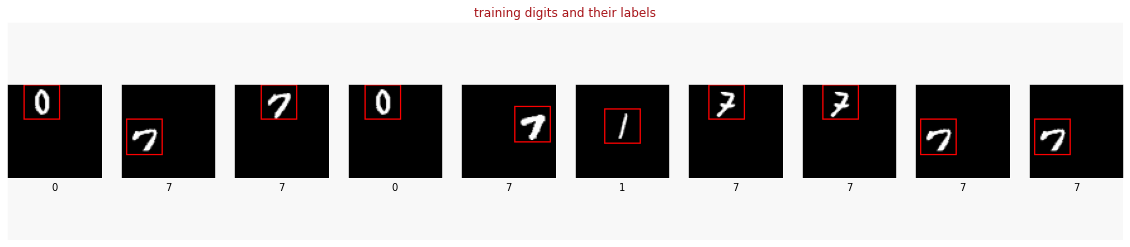

In [202]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)
display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")

In [84]:
class CNNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.l_relu = torch.nn.LeakyReLU(0.1)
    
    def forward(self, input):
        x = self.conv(input)
        x = self.bn(x)
        return self.l_relu(x)

In [11]:
class YoloV1(nn.Module):
    def __init__(self, in_channels=1, **kwargs):
        super(YoloV1, self).__init__()
        self.in_channels = in_channels
        self.darknet_params = [
            (7, 64, 2, 3), 
            'M',  # 1
            (3, 192, 1, 1), 
            'M',  # 2
            (1, 128, 1, 0),
            (3, 256, 1, 1), 
            (1, 256, 1, 0),
            (3, 512, 1, 1), 
            'M',  # 3
            [(1, 256, 1, 0), (3, 512, 1, 1), 4], 
            (1, 512, 1, 0), 
            (3, 1024, 1, 1), 
            'M',  # 4
            [(1, 512, 1, 0), (3, 1024, 1, 1), 2], 
            (3, 1024, 1, 1), 
            (3, 1024, 2, 1),
            [(3, 1024, 1, 1), 2]
            ]
        self.darknet = self._create_darknet()
        self.fcs = self._create_fcs(**kwargs)
    

    def _size_output(self, sizeHW, kernel, stride, padding=0):
        output_size = (sizeHW + 2 * padding - (kernel-1)-1)/stride
        output_size = int(output_size + 1)
        return output_size
        
    def _create_darknet(self):
        k=0
        mp=0
        sizeHW = 448
        prev_channel = self.in_channels
        darknet = torch.nn.Sequential()
        for params in self.darknet_params:
            if type(params) is tuple:
                kernel, channel, stride, padding = params
                darknet.add_module(f"CNNBlock_{k}",CNNBlock(in_channels=prev_channel, out_channels=channel, kernel_size=kernel, stride=stride, padding=padding))
                prev_channel = channel
                k+=1
                sizeHW = self._size_output(sizeHW, kernel, stride, padding=padding)
            
            elif type(params) is list:
                for it in range(params[-1]):
                    for sub_params in params[:-1]:
                        kernel, channel, stride, padding = sub_params
                        darknet.add_module(f"CNNBlock_{k}",CNNBlock(in_channels=prev_channel, out_channels=channel, kernel_size=kernel, stride=stride, padding=padding))
                        prev_channel = channel
                        k+=1
                        sizeHW = self._size_output(sizeHW, kernel, stride, padding=padding)
            
            elif params == 'M':
                darknet.add_module(f"MaxPool_{k}", torch.nn.MaxPool2d(kernel_size=2, stride=2))
                mp += 1
                sizeHW = sizeHW / 2

        return darknet


    def _create_fcs(self, split_size, num_boxes, num_classes): #S, B, C
        S, B, C = split_size, num_boxes, num_classes
        output = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1024*S*S, 4096),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, S*S*(C+B*5))
        )
        return output

    def forward(self, input):
        x = self.darknet(input)
        x = self.fcs(x)
        x = x.view(x.size(0), 7, 7, 1*5+10)
        pc = x[:,:,:,0]
        bbx_coord = x[:,:,:,1:5]
        classifier = x[:,:,:,5:]
        return pc, bbx_coord, classifier

In [12]:
darknet = YoloV1(in_channels=1, split_size=7, num_boxes=1, num_classes=10)
summary(darknet, (2, 1, 448, 448))

Layer (type:depth-idx)                   Output Shape              Param #
YoloV1                                   [2, 7, 7]                 --
├─Sequential: 1-1                        [2, 1024, 7, 7]           --
│    └─CNNBlock: 2-1                     [2, 64, 224, 224]         --
│    │    └─Conv2d: 3-1                  [2, 64, 224, 224]         3,136
│    │    └─BatchNorm2d: 3-2             [2, 64, 224, 224]         128
│    │    └─LeakyReLU: 3-3               [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-2                    [2, 64, 112, 112]         --
│    └─CNNBlock: 2-3                     [2, 192, 112, 112]        --
│    │    └─Conv2d: 3-4                  [2, 192, 112, 112]        110,592
│    │    └─BatchNorm2d: 3-5             [2, 192, 112, 112]        384
│    │    └─LeakyReLU: 3-6               [2, 192, 112, 112]        --
│    └─MaxPool2d: 2-4                    [2, 192, 56, 56]          --
│    └─CNNBlock: 2-5                     [2, 128, 56, 56]          --
│    

In [301]:
class YoloMNIST(torch.nn.Module):
    def __init__(self, sizeHW, S, C, B):
        super(YoloMNIST, self).__init__()
        self.S, self.C, self.B = S, C, B
        self.sizeHW = sizeHW

        self.seq = torch.nn.Sequential()        
        self.seq.add_module(f"conv_1", CNNBlock(1, 32, stride=2, kernel_size=7, padding=2))
        self.seq.add_module(f"maxpool_1", torch.nn.MaxPool2d(2))
        self.seq.add_module(f"conv_3", CNNBlock(32, 128, stride=1, kernel_size=3, padding=0))
        self.seq.add_module(f"maxpool_2", torch.nn.MaxPool2d(2))
        self.seq.add_module(f"conv_5", CNNBlock(128, 64, stride=1, kernel_size=1, padding=0))
        self.seq.add_module(f"conv_4", CNNBlock(64, 128, stride=1, kernel_size=3, padding=0))
        self.seq.add_module(f"conv_6", CNNBlock(128, 128, stride=1, kernel_size=3, padding=1))
        
        # self.seq.add_module(f"maxpool_2", torch.nn.MaxPool2d(2))
        # self.seq.add_module(f"conv_7", CNNBlock(128, 64, stride=1, kernel_size=1, padding=0))
        # self.seq.add_module(f"conv_8", CNNBlock(64, 128, stride=1, kernel_size=3, padding='same'))
        # self.seq.add_module(f"conv_9", CNNBlock(128, 128, stride=1, kernel_size=1, padding='same'))

        self.fcs = self._create_fcs()

        # sizeHW = self._size_output(sizeHW, 7, 2, padding=2)
        # sizeHW = self._size_output(sizeHW, None, None, None, True)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, None, None, None, True)
        # sizeHW = self._size_output(sizeHW, 1, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=1)

        # sizeHW = self._size_output(sizeHW, 3, 1, padding='same')
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, 1, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, None, None, None, True)
        # sizeHW = self._size_output(sizeHW, 1, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding='same')
        # sizeHW = self._size_output(sizeHW, 3, 1, padding='same')


        # sizeHW = self._size_output(sizeHW, None, None, None, True)


        # sizeHW = self._size_output(sizeHW, 1, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=0)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=1)
        # sizeHW = self._size_output(sizeHW, 3, 1, padding=1)



    def _size_output(self, sizeHW, kernel, stride, padding=0, isMaxPool=False):
        if isMaxPool == True:
            output_size = int(sizeHW/2)
            print(output_size)
            return output_size
        if padding == 'same':
            output_size = sizeHW
            print(output_size)
            return output_size
        else:
            output_size = (sizeHW + 2 * padding - (kernel-1)-1)/stride
            output_size = int(output_size + 1)
            print(output_size)
            return output_size

    def _create_fcs(self): #S, B, C
        output = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * self.S * self.S, 4096),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, self.S * self.S * (self.C + self.B*5))
        )
        return output

    def _relative2absolute(self, bbox_relative):
        cx = bbox_relative[:,:,:,0]
        cy = bbox_relative[:,:,:,1]
        rw = bbox_relative[:,:,:,2]
        rh = bbox_relative[:,:,:,3]

        cx_abs, cy_abs =  self.sizeHW * cx, self.sizeHW * cy
        x_min = cx_abs - (self.sizeHW * (rw/2))
        y_min = cy_abs - (self.sizeHW * (rh/2))
        x_max = cx_abs + (self.sizeHW * (rw/2))
        y_max = cy_abs + (self.sizeHW * (rh/2))
        return x_min, y_min, x_max, y_max

    def intersection_over_union(self, pred_box, true_box):
        pred_box = self._relative2absolute(pred_box)
        true_box = self._relative2absolute(true_box)
        
        xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_box
        xmin_true, ymin_true, xmax_true, ymax_true = true_box

        smoothing_factor = 1e-10

        xmin_overlap = torch.maximum(xmin_pred, xmin_true)
        xmax_overlap = torch.minimum(xmax_pred, xmax_true)
        ymin_overlap = torch.maximum(ymin_pred, ymin_true)
        ymax_overlap = torch.minimum(ymax_pred, ymax_true)

        pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
        true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

        overlap_area = torch.maximum((xmax_overlap - xmin_overlap), torch.Tensor([0]))  * np.maximum((ymax_overlap - ymin_overlap), torch.Tensor([0]))
        union_area = (pred_box_area + true_box_area) - overlap_area
        
        iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

        return iou

    def forward(self, input, true_box=False):
        x = self.seq(input)
        x = self.fcs(x)
        x = x.view(x.size(0), self.S, self.S, self.B * 5 + self.C)
        bbx_coord = x[:,:,:,1:5]
        classifier = x[:,:,:,5:]
        pc = pc = x[:,:,:,0]
        return pc, bbx_coord, classifier

In [302]:
learning_rate = 0.001
BATCH_SIZE = 64

model_MNIST = YoloMNIST(sizeHW=75, S=6, C=10, B=1)
model_MNIST = model_MNIST.to(device)
optimizer = torch.optim.Adam(params=model_MNIST.parameters(), lr=learning_rate)
isDigit_loss = torch.nn.MSELoss()
regression_loss = nn.MSELoss()
classification_loss = nn.CrossEntropyLoss()

print(optimizer)
summary(model_MNIST, input_size = (BATCH_SIZE,1,75,75))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Layer (type:depth-idx)                   Output Shape              Param #
YoloMNIST                                [64, 6, 6]                --
├─Sequential: 1-1                        [64, 128, 6, 6]           --
│    └─CNNBlock: 2-1                     [64, 32, 37, 37]          --
│    │    └─Conv2d: 3-1                  [64, 32, 37, 37]          1,568
│    │    └─BatchNorm2d: 3-2             [64, 32, 37, 37]          64
│    │    └─LeakyReLU: 3-3               [64, 32, 37, 37]          --
│    └─MaxPool2d: 2-2                    [64, 32, 18, 18]          --
│    └─CNNBlock: 2-3                     [64, 128, 16, 16]         --
│    │    └─Conv2d: 3-4                  [64, 128, 16, 16]         36,864
│    │    └─BatchNorm2d: 3-5             [64, 128, 16, 16]         256
│    │    └─LeakyReLU: 3-6               [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-4                    [64, 128, 8, 8]           --
│    └─CNNBlock: 2-5                     [64, 64, 8, 8]            --
│    │ 

In [304]:
delta_time = datetime.timedelta(hours=1)
timezone = datetime.timezone(offset=delta_time)

t = datetime.datetime.now(tz=timezone)
str_t = '{:%Y-%m-%d %H:%M:%S}'.format(t)
print(f"[START] : {str_t} :")
print(f"[Training on] : {str(device).upper()}")

EPOCHS = 1
size_grid = 6
training_losses_list = []
box_losses_list = []
class_losses_list = []
pc_losses_list = []
model_MNIST = model_MNIST.to(device)

for epoch in range(EPOCHS) : 
    begin_time = timer()
    training_losses = 0
    
    print("-"*20)
    str_t = '{:%Y-%m-%d %H:%M:%S}'.format(t)
    print(" "*5 + f"{str_t} : EPOCH {epoch+1}/{EPOCHS}")
    print("-"*20)

    model_MNIST.train()
    for batch, (img, labels, bbox_coords, pc) in enumerate(training_dataset):
        begin_batch_time = timer()
        img, labels, bbox_coords, pc = img.to(device), labels.to(device), bbox_coords.to(device), pc.to(device)
        optimizer.zero_grad()
        
        [pc_preds, bbox_coords_preds, label_preds] = model_MNIST(img)
        for i in range(size_grid):
            for j in range(size_grid):
                pc_preds[:, i, j] = 


        class_loss = classification_loss(label_preds, labels)
        box_loss = regression_loss(bbox_coords_preds, bbox_coords)
        pc_loss = isDigit_loss(pc_preds, pc)

        training_loss = box_loss + class_loss + pc_loss
        training_loss.backward()
        
        optimizer.step()
        
        ######### print part #######################
        training_losses += training_loss.item()
        training_losses_list.append(training_loss)
        box_losses_list.append(box_loss.item())
        class_losses_list.append(class_loss.item())
        pc_losses_list.append(pc_loss.item())

        if batch+1 <= len_training_ds//BATCH_SIZE:
            current_training_sample = (batch+1)*BATCH_SIZE
        else:
            current_training_sample = (batch)*BATCH_SIZE + len_training_ds%BATCH_SIZE
        
        if (batch+1) == 1 or (batch+1)%100 == 0 or (batch+1) == len_training_ds//BATCH_SIZE +1:
            print(f" --- Image : {current_training_sample}/{len_training_ds}",\
                  f" : loss = {training_loss:.5f}", \
                  f", classification loss = {class_loss.item():.5f}", \
                  f", bounding box loss = {box_loss.item():.5f}", \
                  f", pc loss = {pc_loss.item():.5f}")
            if batch+1 == (len_training_ds//BATCH_SIZE)+1:
                print(f"Total elapsed time for training : {datetime.timedelta(seconds=timer()-begin_time)}")
                print(f"Mean training loss for this epoch : {training_losses / len(training_dataset):.5f}")
    training_losses /= len(training_dataset)

[START] : 2022-08-14 19:44:19 :
[Training on] : MPS
--------------------
     2022-08-14 19:44:19 : EPOCH 1/1
--------------------


In [309]:
label_preds.shape

torch.Size([64, 6, 6, 10])

In [310]:
pc_preds.shape

torch.Size([64, 6, 6])